In [1]:
import exploration as pde
from functools import partial
import numpy as np
import math
from math import pi

In [2]:
params, conf = pde.load_parameters("long_run_fixed_diff.conf")

In [3]:
# Example of simulation, using the molecular model
# First array corresponds to diffusion, second array to the ci
# Note: this object is built internaly by the gaussian_simulation function
indiv = pde.Individual_Non_Dim([10**(-2.75),10**(-0.15)],[0.013889, 1.137028, 0.412633, 0.000016])
print(indiv.pde())

{'u0': 'u1 * ((u0 * u0)/(1+0.013889 * u0 * u0) + 1.137028) - 0.412633 * u0 + 0.0017782794100389228 * laplace(u0)', 'u1': '1- u1 * ((u0 * u0)/(1+0.013889 * u0* u0) + 1.6e-05) + 0.7079457843841379 * laplace(u1)'}


In [4]:
from scipy.signal import find_peaks
from pde import PDE, CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph, UnitGrid, FieldCollection, PlotTracker
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [7]:
# Fitting
def gaussian(x,a, b, mu,sigma):
    return a/(np.sqrt(2*pi*sigma*sigma))*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma)) + b
# Extract g1, g2
def convert(a, sigma,factor=4.0):
    return [a/(factor*np.sqrt(2*np.pi*sigma*sigma)),sigma]

def plot_indiv(arr, fig_name=None, **kwargs):
    # Performing a simulation
    grid, sim = pde.gaussian_simulation(arr, param_ranges=None, diffusion_params=[10**(-2.75),10**(-0.15)], dt=float(conf["dt"]))
    # Finding peaks and fitting a Gaussian function on it
    fitness_scale = 100.0
    xdata = grid.axes_coords[0]
    ydata = sim.data[0]
    ydata = np.concatenate([ydata,ydata]) #so that we can find peaks despite the periodicity
    peaks, features = find_peaks(ydata,width=2,prominence=1.0)
    f = plt.figure()
    if not math.isnan(ydata[0]) and len(peaks)>0:
        #find the widest peak
        id_peak = np.argmax(np.array(features['widths']))
        relevant_xdata = xdata[:features['right_bases'][id_peak]-features['left_bases'][id_peak]] #we match the length
        relevant_ydata = ydata[features['left_bases'][id_peak]:features['right_bases'][id_peak]]
        try:
            popt, pcov = curve_fit(gaussian, relevant_xdata, relevant_ydata,bounds=(0, [100., 100., 100., 100.0]))
            fitness = np.linalg.norm(relevant_ydata-gaussian(relevant_xdata, *popt))/fitness_scale
        except Exception as e:
            print(e)
            popt = [-1,-1,-1,-1]
    plt.plot(relevant_xdata,relevant_ydata)
    plt.plot(relevant_xdata,gaussian(relevant_xdata, *popt))
    if fig_name is not None:
        f.savefig(fig_name, **kwargs)
    print("{g1, g2}:",convert(popt[0],popt[3]), "Gaussian fit:", fitness)

{g1, g2}: [0.46817650785859616, 0.24811983804887408] Gaussian fit: 0.001387189654564728


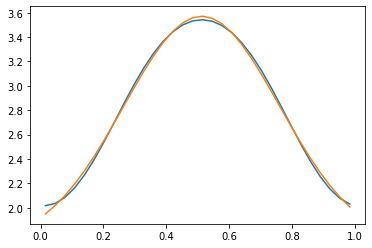

In [8]:
# Plotting the molecular concentration profile with evaluation of its parameters and saving it.
plot_indiv([0.013889, 1.137028, 0.412633, 0.000016], "figsup.eps", bbox_inches='tight')